## Exploratory data analysis 

__Introduction__


This is the primary notebook that dives into the dataset to explore the best method to do data preprocessing for the model. We also explore all the information available in the metadata and shortlist best practises for pre-processing the data.

__Kaggle_Score__ : NA

In [1]:
import os 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
import PIL
from PIL import Image
import plotly.express as px
from tqdm.notebook import tqdm

In [2]:
import gc
import os
import glob
import sys
import cv2
import imageio
import joblib
import math
import random
#import wandb
import math

import numpy as np
import pandas as pd

from scipy.stats import kstest
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from statsmodels.graphics.gofplots import qqplot

plt.rcParams.update({'font.size': 18})
plt.style.use('fivethirtyeight')

import seaborn as sns
import matplotlib

from termcolor import colored

from multiprocessing import cpu_count
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr
import timm
import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
res_path = "petfinder-pawpularity-score/"
train_df = pd.read_csv(os.path.join(res_path,'train.csv'))
test_df = pd.read_csv(os.path.join(res_path,'test.csv'))

In [5]:
train_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  
0          0      1        0      0          0     0     0           63  
1          0      0        0      0          0     0     0           42  
2          0      0        0      1          1     0     0           28  
3          0      0        0      0          0     0     0           15  
4          0      1        0      0          0     0     0           72

In [6]:
train_df.describe()

Subject Focus         Eyes         Face         Near       Action  \
count    9912.000000  9912.000000  9912.000000  9912.000000  9912.000000   
mean        0.027643     0.772599     0.903955     0.861582     0.009988   
std         0.163957     0.419175     0.294668     0.345356     0.099444   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%         0.000000     1.000000     1.000000     1.000000     0.000000   
50%         0.000000     1.000000     1.000000     1.000000     0.000000   
75%         0.000000     1.000000     1.000000     1.000000     0.000000   
max         1.000000     1.000000     1.000000     1.000000     1.000000   

         Accessory        Group      Collage        Human    Occlusion  \
count  9912.000000  9912.000000  9912.000000  9912.000000  9912.000000   
mean      0.067797     0.129338     0.049637     0.166263     0.172014   
std       0.251409     0.335591     0.217204     0.372335     0.377411   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              Info         Blur  Pawpularity  
count  9912.000000  9912.000000  9912.000000  
mean      0.061239     0.070420    38.039044  
std       0.239780     0.255866    20.591990  
min       0.000000     0.000000     1.000000  
25%       0.000000     0.000000    25.000000  
50%       0.000000     0.000000    33.000000  
75%       0.000000     0.000000    46.000000  
max       1.000000     1.000000   100.000000

In [7]:
train_df.nunique()

Id               9912
Subject Focus       2
Eyes                2
Face                2
Near                2
Action              2
Accessory           2
Group               2
Collage             2
Human               2
Occlusion           2
Info                2
Blur                2
Pawpularity       100
dtype: int64

__Insights__
1. All meta data values are binary

### Distribution of Pawpularity

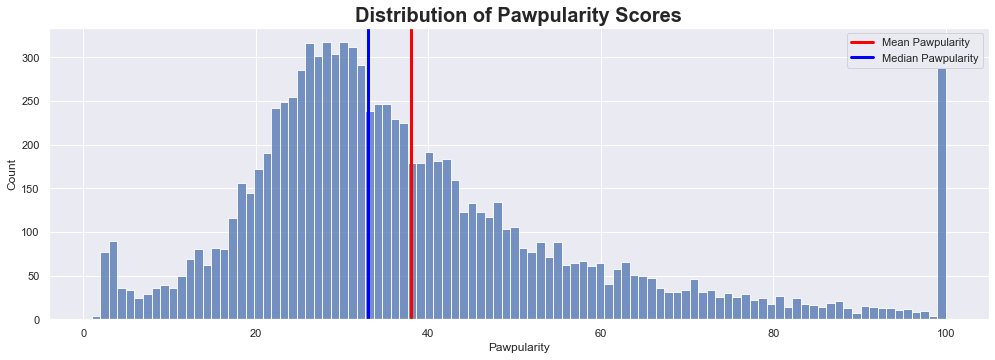

In [8]:
#Lets see a the distribution of Pawpularity Scores
sns.set(rc={'figure.figsize':(15,5)})
fig = plt.figure()
sns.histplot(data=train_df, x='Pawpularity', bins=100)
plt.axvline(train_df['Pawpularity'].mean(), c='red', ls='-', lw=3, label='Mean Pawpularity')
plt.axvline(train_df['Pawpularity'].median(),c='blue',ls='-',lw=3, label='Median Pawpularity')
plt.title('Distribution of Pawpularity Scores', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

In [9]:
def get_image_file_path(image_id):
    return f'petfinder-pawpularity-score/train/{image_id}.jpg'

train_df['file_path'] = train_df['Id'].apply(get_image_file_path)

In [10]:
def show_batch_df(df, rows=2, cols=3,filename='image.png'):
    df = df.copy().reset_index()
    fig, axes = plt.subplots(figsize=(cols*8, rows*8))
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            img = Image.open(df.loc[idx, 'file_path'])
            plt.subplot(rows,cols,idx+1)
            plt.axis('off')
            ax = plt.subplot(f"{rows}{cols}{idx+1}")
            ax.set_title(f'Pawpularity: {df.loc[idx, "Pawpularity"]}')
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt.savefig(filename, bbox_inches='tight',pad_inches = 0)
            

### Photos with the least Pawpularity rating

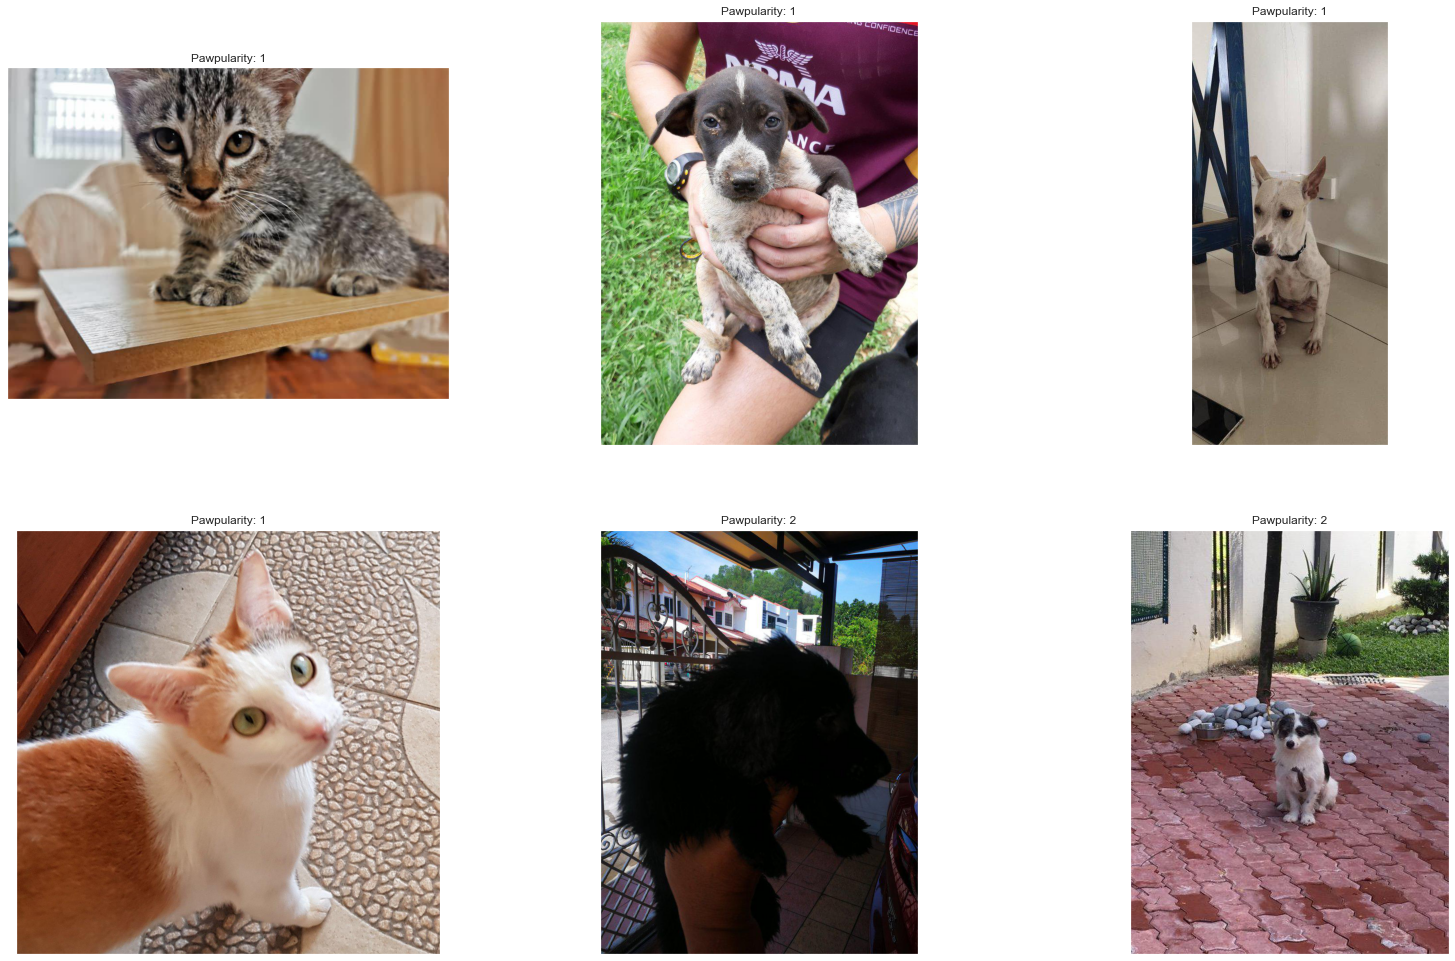

In [11]:
show_batch_df(train_df.sort_values('Pawpularity'),filename='lowest_paw.png')

### Photos with the highest Pawpularity rating

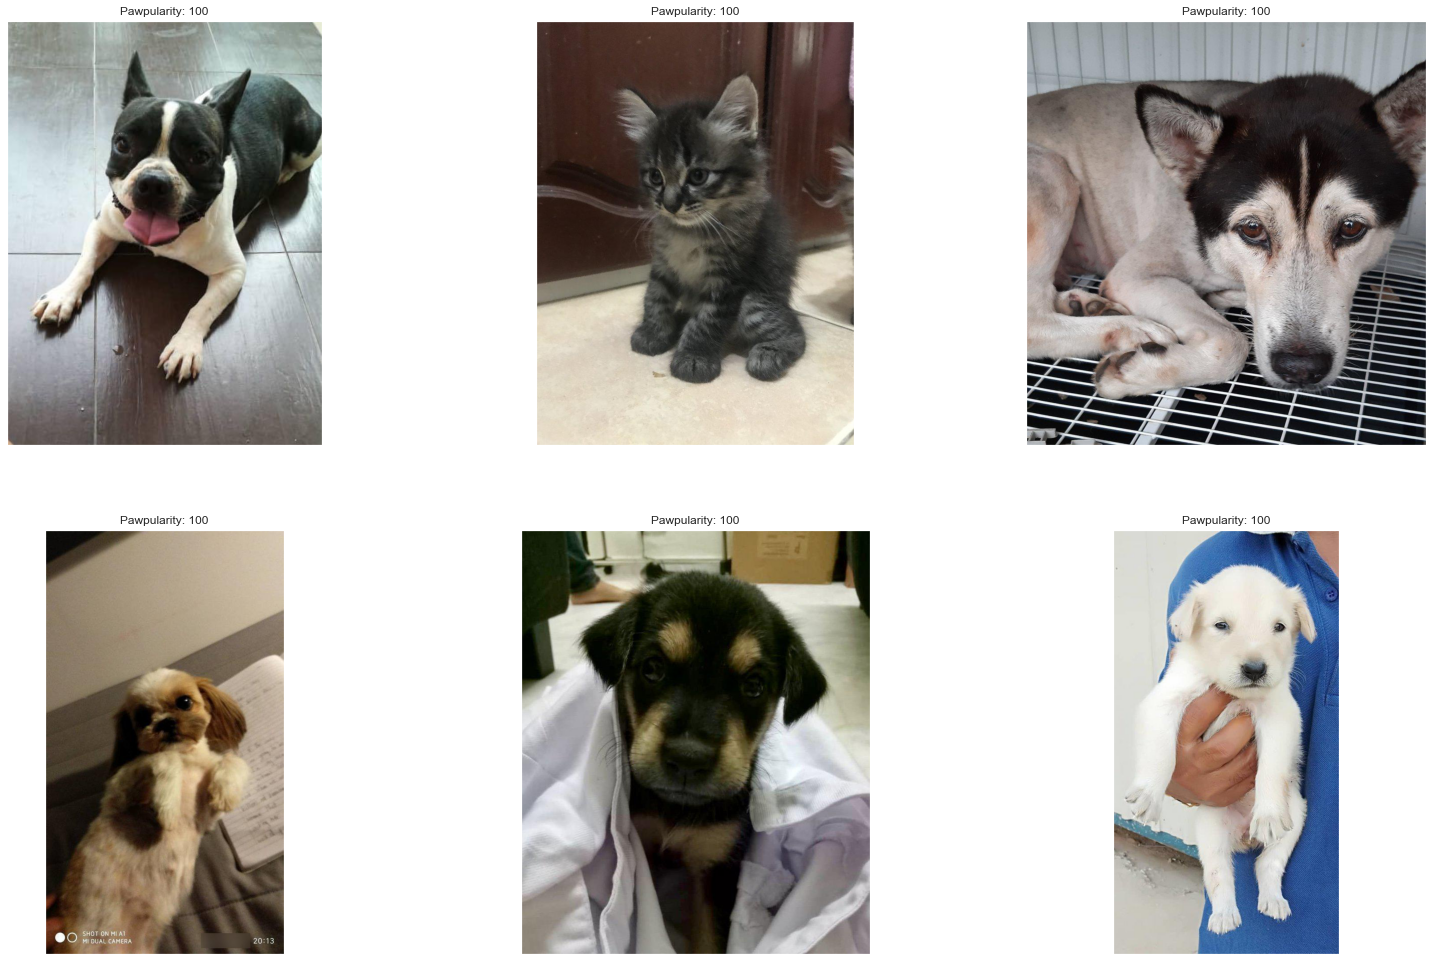

In [12]:
show_batch_df(train_df.sort_values('Pawpularity', ascending=False),filename='highest_paw.png')

### Correlation Matrix

In [13]:
def correlation_matrix(df):
    corrs = df.corr()
    plt.figure(figsize = (14, 10))
    sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

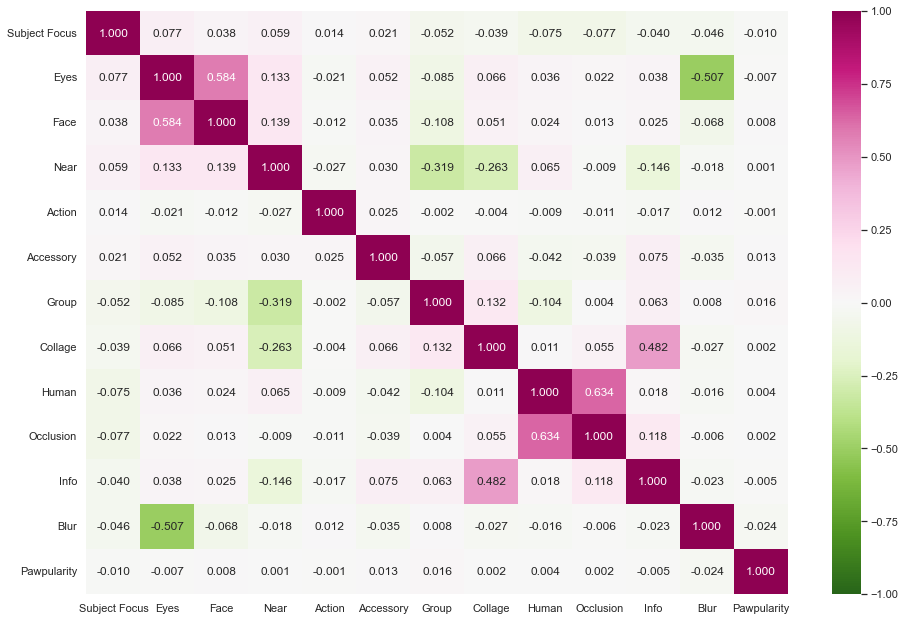

In [14]:
correlation_matrix(train_df)

__Insights__
1. Low values of correlation with pawpularity indicates that none of the input features have a linear relation with the output.
2. This is expected as all the metadata is binary so linear relationships are unlikely.
3. This also show high correlation between occlussion and human presence in the image. This indicates that if a human is present it is difficult to seperate two or more object.

### Plotting metadata Information to find some correlation

In [15]:
# Creating a plotly visualization function
def stacked_percentage_hist(viz,source,target):
    viz['Count'] = 1
    viz_g  = viz.groupby([source,target])['Count'].sum().reset_index()
    viz_g['percentage'] = viz.groupby([source, target]).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
    viz_g[target] = viz_g[target].astype(str)
    viz_g[source] = viz_g[source].astype(str)
    fig = px.bar(viz_g, x=source, y="Count", color=target,
                 text=viz_g['percentage'].apply(lambda x: '{0:1.2f}%'.format(x)),
                 category_orders={"paw_group": paw_labels},
                 color_discrete_sequence=px.colors.qualitative.Pastel1)
    fig.show()

In [16]:
viz = train_df.copy()
paw_labels = ['0-10','10-20','20-30','30-40','40-50','50-60', '60-70', '70-80','80-90','90-100']
viz['paw_group'] = pd.cut(train_df.Pawpularity, range(0,110,10), right=False, labels=paw_labels)
discrete_cols = [i for i in list(viz.columns) if viz[i].nunique() < 3 and i !='Count']
for column in discrete_cols:
    stacked_percentage_hist(viz.copy(),'paw_group',column)

__Insights__
1. All the metadata is evenly distributed across various bins.This indicates that not much information can be extracted from this data since it is hard to exactly evaluate the target column if there are no variations across different bins.
2. All the metadata also shows a matching gaussian distribution similar to the target variable.

#### Word Cloud Visualization

In [17]:
text = 'Dog Cat Happy Sad Color Black&White Amusing Fluffy Sleepy Snuggly Outside Inside Relaxed Restless Energetic Leashed Hair Legs Ears'
text += 'Small Large Breed Playing Tail Stripes Size Quality'
text  += ' '.join(list(train_df.columns))
from wordcloud import WordCloud
import matplotlib.pyplot as plt

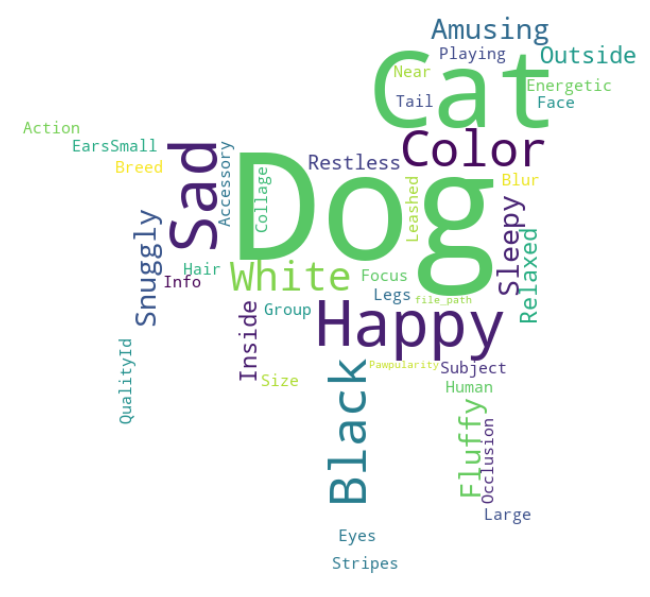

<Figure size 1440x720 with 0 Axes>

In [18]:
mask = np.array(Image.open('pngwing.com.png'))
wc = WordCloud(mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0])
wc.generate(text)
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()
plt.savefig("WordCloud", bbox_inches='tight',pad_inches = 0)

#### Dependency on image quality and aspect ratio

In [19]:
widths = []
heights = []
ratios = []
pixels = []
for file_path in tqdm(train_df['file_path']):
    image = imageio.imread(file_path)
    h, w, _ = image.shape
    heights.append(h)
    widths.append(w)
    ratios.append(w / h)
    pixels.append(w*h)

In [20]:
train_df['Widths'] = widths
train_df['Heights'] = heights
train_df['Ratios'] = ratios
train_df['Pixels'] = pixels

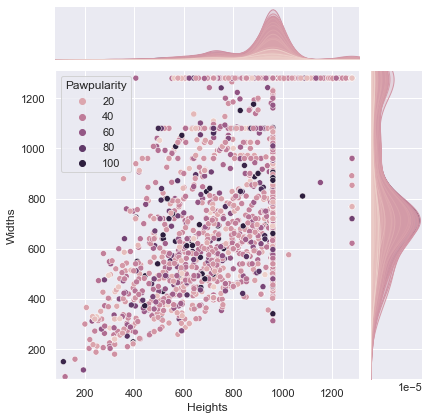

In [21]:
p = sns.jointplot(data=train_df, x="Heights", y="Widths",hue='Pawpularity')
p.ax_marg_x.set_xlim(80, 1310)
p.ax_marg_y.set_ylim(80, 1310);

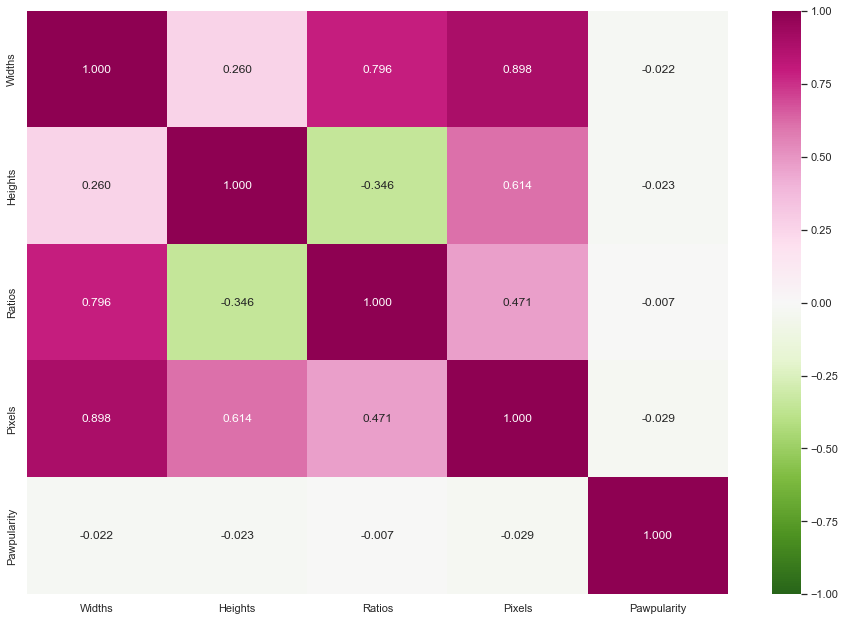

In [22]:
new_df = train_df[["Widths", "Heights","Ratios","Pixels","Pawpularity"]]
correlation_matrix(new_df)

__Insights__
1. Analysis indicates the Pawpularity value has little to no correlation with the height,width or number of pixels the image has.
2. This indicates that the dataset is designed specifically such that only the content of the photo can provide good estimation of Pawpularity

__Final_Observations__

1. All the basic information extracted from the image data indicated that the dataset is uniformly distributed and no linear correlation was found between any of the available metadata or the extracted features such as image quality and aspect ratio.
2. This showed that basic regression based techniques that extract simple information from image will not give good result. This is proved by a metadata only model created in another notebook which gives an RMSE value higher than 20.
3. That said, based on this analysis we realised that since the input dataset is class imbalanced we need to select data pre-processing techniques that improve results for dataset that has features uniformly distributed across the target.This resulted in selecting Stratified K-fold validation technique instead of simple K-fold validation for our Swim Transformer based model.
5. As far as the image data is concerned features such as brightness, contrast count of dogs/cats etc. also didnt show any form of bias. Images with low score also had good brightness and contrast still scored less based on the features of the animal present. This indcated that a detailed analysis of smaller subsections of image data is expected to give best results. To this effect we choose the swin transformer based model that divides the image in 4 * 4 * 3 pixels and extra useful information from it before merging data from negihbouring sub-divisions of the image. 